In [ ]:
!pip install pillow==4.1.1

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import tensorflow as tf
from sklearn.cluster import AgglomerativeClustering

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [ ]:
cd gdrive/MyDrive/ML_project_data/pictures/

/content/gdrive/.shortcut-targets-by-id/1Pq6YAd5542Bw36m_pWOnZiNxfcJ5vdDS/ML_project_data/pictures


In [ ]:
from google.colab import auth
auth.authenticate_user()
import gspread
from google.auth import default
creds, _ = default()

gc = gspread.authorize(creds)
worksheet = gc.open('images_name.csv').sheet1
rows = worksheet.get_all_values()
df = pd.DataFrame.from_records(rows) 

In [ ]:
df_im = df.head(1500)
df_im.head()

,0,1,2
0,image_name,longest_comment,comments_5
1,1000092795,Two young guys with shaggy hair look at their ...,0 | Two young guys with shaggy hair look at...
2,10002456,Several men in hard hats are operating a giant...,5 Several men in hard hats are operating a ...
3,1000268201,A child in a pink dress is climbing up a set o...,10 | A child in a pink dress is climbing up...
4,1000344755,Someone in a blue shirt and hat is standing on...,15 | Someone in a blue shirt and hat is sta...


In [ ]:
images = df_im[0][1:]
images = list(images)
images[0]

'1000092795'

In [ ]:
data = {
    'flattenPhoto' : [],
    'photoclass' : [],
    'photoclasskmeans' : [],
    'image_name' : []
    }

In [ ]:
MyModel = tf.keras.models.Sequential()
MyModel.add(tf.keras.applications.ResNet50(
    #include_top = True, weights=None,pooling=None,classes = 5, classifier_activation = 'softmax'
    include_top = False, weights='imagenet',    pooling='avg',
))
MyModel.layers[0].trainable = False

In [ ]:
def LoadDataAndDoEssentials(path, h, w):
    img = mpimg.imread(path)
    img = cv2.resize(img, (h, w))
    ## Expanding image dims so this represents 1 sample
    img = np.expand_dims(img, 0)
    img = tf.keras.applications.resnet50.preprocess_input(img)
    extractedFeatures = MyModel.predict(img)
    classes_x=np.argmax(extractedFeatures,axis=1)[0]
    extractedFeatures = np.array(extractedFeatures)
    data['photoclass'].append(classes_x)
    data['flattenPhoto'].append(extractedFeatures.flatten())

In [ ]:
def ReadAndStoreMyImages(path):
    for i in images:
        imagePath = f"{path}/{i}.jpg"
        data['image_name'].append(i)
        LoadDataAndDoEssentials(imagePath, 224, 224)

In [ ]:
imagePath = "image_dataset/10002456.jpg"
im = mpimg.imread(imagePath)

In [ ]:
ReadAndStoreMyImages('image_dataset')

In [ ]:
Training_Feature_vector = np.array(data['flattenPhoto'], dtype = 'float64')
kmeans = AgglomerativeClustering(n_clusters = 5)
k = kmeans.fit_predict(Training_Feature_vector)
data['photoclasskmeans'] = k

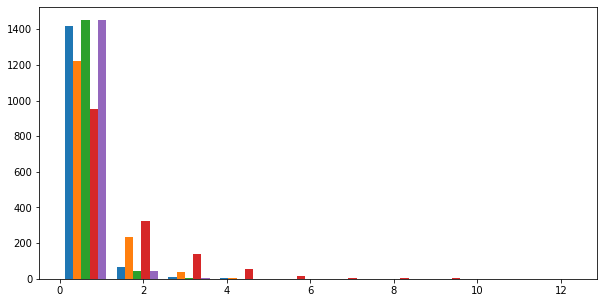

In [ ]:
dimReducedDataFrame = pd.DataFrame(Training_Feature_vector)
dimReducedDataFrame = dimReducedDataFrame.rename(columns = { 0: 'V1', 1 : 'V2', 2 :'V3', 3 : 'V4',4: 'V5'})
x = [dimReducedDataFrame['V1'], dimReducedDataFrame['V2'], dimReducedDataFrame['V3'],dimReducedDataFrame['V4'],dimReducedDataFrame['V5']]
plt.figure(figsize = (10, 5))
plt.hist(x = x)
plt.show()

In [ ]:
data = pd.DataFrame(data)
data = data.sort_values('photoclass').reset_index()

In [66]:
data.head(10)

,index,flattenPhoto,photoclass,photoclasskmeans,image_name
0,1078,"[1.3859904, 1.275703, 0.30141994, 7.364384, 1....",3,2,133280380
1,787,"[0.34437042, 0.10638516, 0.0, 12.394428, 0.210...",3,2,126042604
2,583,"[0.048443943, 0.6345056, 0.0, 5.9613447, 0.061...",3,2,118939861
3,284,"[0.7945638, 1.337263, 0.2730246, 0.18258385, 0...",5,3,1096097967
4,1397,"[0.75358886, 0.0, 0.00670343, 1.8252532, 0.212...",7,2,1404471863
5,867,"[0.18512839, 0.31934902, 0.2578488, 0.7481743,...",8,1,128395441
6,663,"[0.41304538, 0.17377032, 0.17240454, 2.2810209...",8,1,1223671563
7,217,"[0.7679215, 0.1986859, 0.32439515, 3.9587014, ...",8,0,1076460267
8,39,"[0.027015569, 0.08532012, 0.043271117, 3.07562...",8,0,1010087623
9,1277,"[0.5362914, 1.3631399, 0.29243073, 1.1145055, ...",8,1,137422713


In [ ]:
data.groupby('photoclasskmeans').count()

,index,flattenPhoto,photoclass,image_name
photoclasskmeans,,,,
0,434,434,434,434
1,341,341,341,341
2,393,393,393,393
3,244,244,244,244
4,87,87,87,87


In [ ]:
for i in range(5):
  if i == 0:
    data_0 = data.loc[data['photoclasskmeans'] == i].groupby('photoclass').count()
    data_0 = data_0.reset_index()
    data_0['photoclasskmeans'] = data_0['photoclasskmeans'].apply(lambda x : i)
  elif i == 1:
    data_1 = data.loc[data['photoclasskmeans'] == i].groupby('photoclass').count()
    data_1 = data_1.reset_index()
    data_1['photoclasskmeans'] = data_1['photoclasskmeans'].apply(lambda x : i)
  elif i == 2:
    data_2 = data.loc[data['photoclasskmeans'] == i].groupby('photoclass').count()
    data_2 = data_2.reset_index()
    data_2['photoclasskmeans'] = data_2['photoclasskmeans'].apply(lambda x : i)
  elif i == 3:
    data_3 = data.loc[data['photoclasskmeans'] == i].groupby('photoclass').count()
    data_3 = data_3.reset_index()
    data_3['photoclasskmeans'] = data_3['photoclasskmeans'].apply(lambda x : i)
  elif i == 4:
    data_4 = data.loc[data['photoclasskmeans'] == i].groupby('photoclass').count()
    data_4 = data_4.reset_index()
    data_4['photoclasskmeans'] = data_4['photoclasskmeans'].apply(lambda x : i)

In [ ]:
photoclass_df	= data.groupby('photoclass').count().reset_index()

In [ ]:
classes_df = {
    'classnumber' : [],
    'clusternumber': []
}

In [ ]:
for c in list(photoclass_df['photoclass']):
  if c in list(data_0['photoclass']):
      classes_df['classnumber'].append(c)
      classes_df['clusternumber'].append(0)
  if c in list(data_1['photoclass']):
      classes_df['classnumber'].append(c)
      classes_df['clusternumber'].append(1)
  if c in list(data_2['photoclass']):
      classes_df['classnumber'].append(c)
      classes_df['clusternumber'].append(2)
  if c in list(data_3['photoclass']):
      classes_df['classnumber'].append(c)
      classes_df['clusternumber'].append(3)
  if c in list(data_4['photoclass']):
      classes_df['classnumber'].append(c)
      classes_df['clusternumber'].append(4)



In [ ]:
classes_df['classnumber']=np.array(classes_df['classnumber'])
classes_df['clusternumber']=np.array(classes_df['clusternumber'])

In [ ]:
len(classes_df['clusternumber']) , len(classes_df['classnumber'])

(642, 642)

In [ ]:
classes_df = pd.DataFrame(classes_df)

In [ ]:
g_im = data.groupby('photoclasskmeans')
g_im = pd.DataFrame(g_im)

In [ ]:
for i in range(5):
  if i == 0:
    img_0 = list(g_im[1][i]['image_name'])
  if i == 1:
    img_1 = list(g_im[1][i]['image_name'])
  if i == 2:
    img_2 = list(g_im[1][i]['image_name'])
  if i == 3:
    img_3 = list(g_im[1][i]['image_name'])
  if i == 4:
    img_4 = list(g_im[1][i]['image_name'])
  
  


In [ ]:
len(img_0)+len(img_1)+len(img_2)+len(img_3)+len(img_4) == len(data) , len(data)

(True, 1499)

In [ ]:
l = classes_df.groupby('classnumber')
l =  pd.DataFrame(l)

In [ ]:
p = []
g_c = []
for a, b in l.itertuples(index=False):
  p.append(b)
for i in range(len(p)):
  g_c.append(list(p[i]['clusternumber']))



In [ ]:
grouped_classes_df = {
    'classnumber' : [],
    'clusternumber': []
}

In [ ]:
grouped_classes_df['classnumber']=photoclass_df['photoclass']
grouped_classes_df['clusternumber']=np.array(g_c)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


In [ ]:
grouped_classes_df = pd.DataFrame(grouped_classes_df)

In [ ]:
grouped_classes_df

,classnumber,clusternumber
0,3,[2]
1,5,[3]
2,7,[2]
3,8,"[0, 1]"
4,9,"[0, 1]"
...,...,...
428,1996,"[1, 3]"
429,2020,"[1, 2]"
430,2028,[2]
431,2030,[1]


In [ ]:
n = []
for i in range(len(grouped_classes_df)):
  if len(grouped_classes_df['clusternumber'][i]) > 1:
    n.append(1)
len(n)

142